This notebook uses the output database from https://www.kaggle.com/nickrood/can-star-power-predict-box-office-revenue/output
In that notebook I made predictions with a linear and random forest regressor model, but I also want to see how well a XGBoost model works on the data becasue it seems to outperform a lot of other algorithms. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.
#insert submission file
df_submission=pd.read_csv('../input/tmdb-box-office-prediction/sample_submission.csv')
df_submission.head(1)



['tmdb-2', 'tmdb-box-office-prediction']


,id,revenue
0,3001,1000000


In [134]:
#insert commbined dataset with 78 features and target
df_tmdb = pd.read_csv("../input/tmdb-2/tmdb.csv")
df_tmdb.head(5)

,budget,popularity,runtime,avg_star_power,avg_star_power_total,homepage,Music,Thriller,Family,Horror,Crime,History,War,Western,Documentary,Fantasy,Action,Mystery,Animation,TV Movie,Science Fiction,Foreign,Comedy,Romance,Adventure,Drama,avg_crew_power,avg_crew_power_total,belongs_to_collection,avg_production_power,avg_production_power_total,production_USA,cast_len,crew_len,production_companies_len,production_countries_len,keywords_len,genres_len,original_title_letter_count,original_title_word_count,title_word_count,overview_word_count,tagline_word_count,log_popularity,log_budget,log_revenue,log_avg_star_power,log_avg_star_power_total,log_avg_crew_power,log_avg_crew_power_total,log_avg_production_power,log_avg_production_power_total,release_year,release_month1,release_month2,release_month3,release_month4,release_month5,release_month6,release_month7,release_month8,release_month9,release_month10,release_month11,release_month12,release_dayofweek0,release_dayofweek1,release_dayofweek2,release_dayofweek3,release_dayofweek4,release_dayofweek5,release_dayofweek6,languagesen,languagesen and other,languagesother,release_quarter1,release_quarter2,release_quarter3,release_quarter4
0,-0.233834,-0.159439,-0.685157,-0.218697,0.347904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.628073,-0.596690,1.0,0.464084,0.846064,1,0.174897,1.701546,0.052267,-0.461363,-0.541540,-1.341913,0.863048,1.458382,1.403139,-0.818375,0.722002,0.058267,0.618099,16.326300,0.033738,0.614408,-0.625671,-0.416517,1.128968,1.149782,0.998003,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0
1,0.469679,-0.021872,0.246332,1.343369,0.392058,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,2.311707,1.096437,1.0,1.577861,0.669840,1,-0.012593,-0.523507,-0.839809,-0.461363,-0.541540,1.335654,3.025281,2.085875,2.023923,0.577591,1.174698,0.325424,0.772723,18.370959,1.425402,0.650919,1.904458,1.107009,1.578469,1.082526,0.280932,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
2,-0.523356,4.585709,-0.126263,-0.860306,-0.719588,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.741884,-0.114353,0.0,-0.524268,-0.533344,1,1.678888,1.410938,0.031759,-0.461363,0.758104,-1.369804,-0.818688,-1.051589,-1.079997,-1.097568,0.495653,2.941448,0.405251,16.387512,-1.216422,-0.697551,-0.872978,0.193247,-0.740082,-0.136116,0.932815,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
3,-0.580178,-0.438968,0.665502,-0.598153,-0.667642,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.898132,-1.191710,0.0,-0.559387,-0.670070,0,-0.811461,-0.769754,-0.860316,-0.461363,-0.054174,-0.477282,-0.938812,-1.051589,-1.079997,1.868860,-0.409740,-0.739201,0.256257,16.588099,-0.591966,-0.601270,-1.286199,-1.861521,-1.482717,-1.654931,0.802438,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0
4,-0.612648,-0.605583,0.479204,-0.840359,-0.976721,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.898132,-1.191710,0.0,-0.559387,-0.670070,0,-0.963433,-0.801588,-0.860316,-0.461363,-1.028907,-0.449390,-1.299184,-1.051589,-0.459213,-0.713678,-0.409740,-1.628654,-1.573065,15.182615,-1.159954,-1.285418,-1.286199,-1.861521,-1.482717,-1.654931,0.606873,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0


In [135]:
#insert some libraries
import json
import ast
from pprint import pprint
import seaborn as sns 
from scipy.stats import norm,skew
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from math import sqrt
pd.set_option('display.max_columns', None)

In [136]:
#split tmdb into train and test set
df_train= df_tmdb.iloc[0:3000] # first 3000 rows of the tmdb dataframe
df_test=df_tmdb.iloc[3000:7398]

In [137]:
df_train.shape, df_test.shape

((3000, 79), (4398, 79))

In [138]:
#split data into features and target. All features are either integer, float or dummy.
features = df_train.select_dtypes(include=['int64', 'float64', 'uint8', 'int8']).columns.tolist()
features.remove('log_revenue')
features_unseen = df_test.select_dtypes(include=['int64', 'float64', 'uint8', 'int8']).columns.tolist()
features_unseen.remove('log_revenue')

X, y = df_train[features], df_train['log_revenue']

In [139]:
#split data into train and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(2400, 78) (2400,)
(600, 78) (600,)


First settings, R2=0,36, RMSE 2.45
xg_reg = xgb.XGBRegressor(objective ='reg:linear', 
                          #colsample_bytree = 0.3, #colsample_bytree= percentage of features user per tree. Higher values can lead to overfitting
                          #submsample=0.5, #percentage of samples used per tree. Lower values can lead to underfitting 
                          learning_rate= 0.01,
                          max_depth = 5, 
                          alpha = 0.01, #L1 regularization
                          n_estimators = 10)
model_xgb=xgb.XGBRegressor(max_depth=5,
                           learning_rate=0.1, 
                           n_estimators=2000, 
                           objective='reg:linear', 
                           gamma=1.45, 
                           verbosity=3,
                           subsample=0.25, 
                           colsample_bytree=0.8, 
                           colsample_bylevel=0.50)



In [104]:
#final settings of model
model_xgb=xgb.XGBRegressor(max_depth=5,
                           learning_rate=0.10, 
                           n_estimators=115, 
                           objective='reg:linear', 
                           gamma=10,
                           alpha=0.5,
                           verbosity=3,
                           subsample=0.5, #percentage of samples used per tree. Lower values can lead to underfitting 
                           colsample_bytree=0.8) #percentage of features user per tree. Higher values can lead to overfitting

eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["rmse"]
%time model_xgb.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

In [106]:
#fit model and make predictions 
model_xgb.fit(X_train,y_train)

y_pred=model_xgb.predict(X_test)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [107]:
#look at rmse and R-Squared 
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(y_test, y_pred))


print ("R-Squared is:", metrics.r2_score(y_test, y_pred))
print ("The rmse is:", rmse)

R-Squared is: 0.5022786229077347
The rmse is: 2.0816733818127906


In [108]:
#look at actual and predicted values 
compare = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
compare.head(5)

,Actual,Predicted
1690,8.564268,14.488571
1798,17.362970,17.674397
417,12.830756,14.669289
1599,13.454084,12.413926
1206,15.454883,13.672327


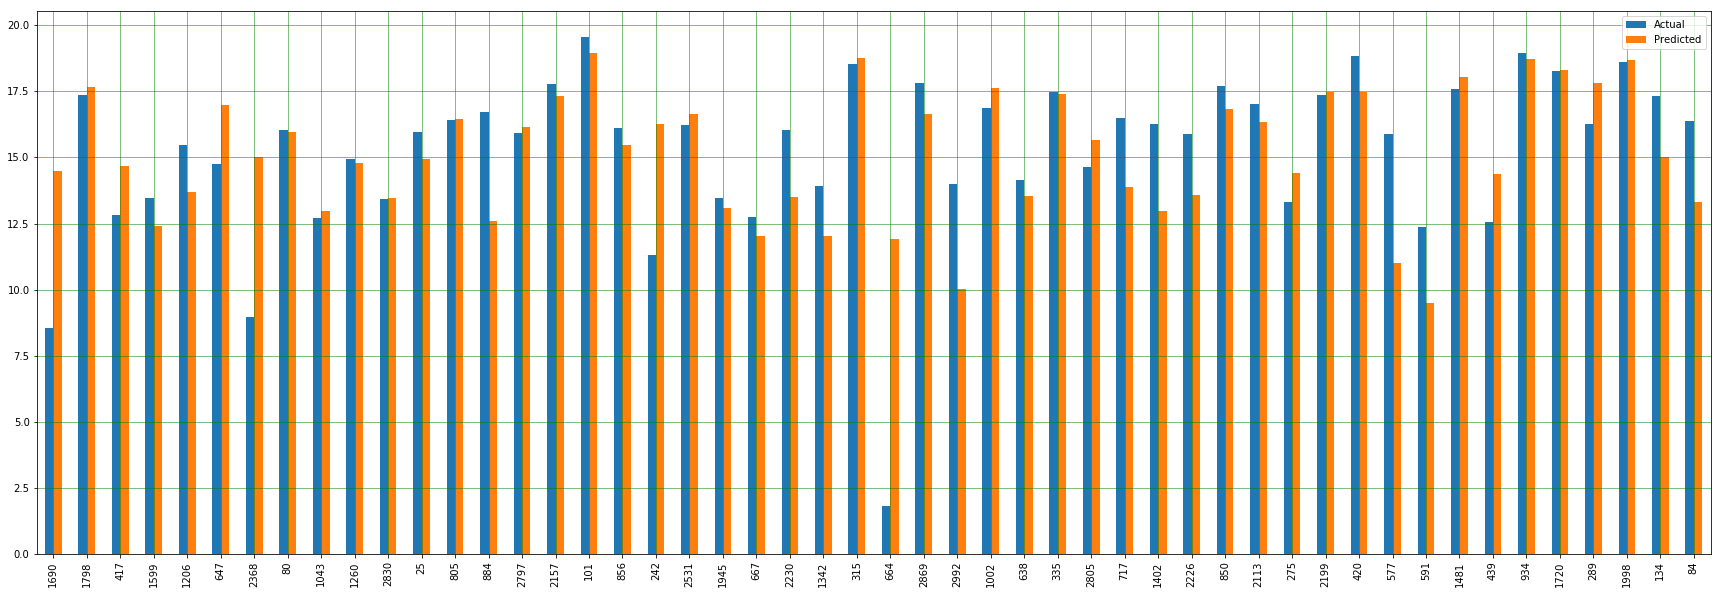

In [109]:
# look at actual and predicted values of first 50 entries in the dataset
compare1 = compare.head(50)
compare1.plot(kind='bar',figsize=(30,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [110]:
#make prediction on unseen test dataset
X_unseen=df_test[features_unseen]
prediction_unseen= model_xgb.predict(X_unseen)

In [111]:
prediction_unseen

array([14.11512 , 13.76225 , 15.936281, ..., 17.762318, 14.914416,
       13.281295], dtype=float32)

In [112]:
df_submission['revenue'] = np.expm1(prediction_unseen)


In [113]:
df_submission.head(5)

,id,revenue
0,3001,1349330.625
1,3002,948131.875
2,3003,8337559.500
3,3004,4986771.000
4,3005,630480.125


In [114]:
df_submission[['id','revenue']].to_csv('submission_xgb1.csv', index=False)

In [140]:
#run model with Kfold splits
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import loadtxt

In [141]:
# k-fold cross validation evaluation of xgboost model

import xgboost
from sklearn.model_selection import KFold

#final settings of model
model_xgb2=xgb.XGBRegressor(max_depth=5,
                           learning_rate=0.10, 
                           n_estimators=115, 
                           objective='reg:linear', 
                           gamma=10,
                           alpha=0.5,
                           verbosity=3,
                           subsample=0.5, #percentage of samples used per tree. Lower values can lead to underfitting 
                           colsample_bytree=0.8) #percentage of features user per tree. Higher values can lead to overfitting
kfold=KFold(n_splits=5, random_state=7)
results = cross_val_score(model_xgb2, X, y, cv=kfold)





/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [142]:
results

array([0.47034902, 0.4378546 , 0.46553763, 0.54366861, 0.51872177])

In [143]:
#fit model and make predictions 
model_xgb2.fit(X_train,y_train)

y_pred2=model_xgb2.predict(X_test)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [144]:
#look at rmse and R-Squared 
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(y_test, y_pred2))


print ("R-Squared is:", metrics.r2_score(y_test, y_pred2))
print ("The rmse is:", rmse)

R-Squared is: 0.5022786229077347
The rmse is: 2.0816733818127906
